# <font color=cyan> Export-Third-Parties </font>

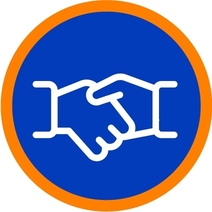

## <font color='yellow'>Code for token genaration and API management</font>

In [91]:
#@title Import modules
import requests, base64
import re
import json as js
import pandas as pd
from io import StringIO
import numpy as np
import csv
import copy




In [92]:
#@title Token generation
#@markdown This code calls the token end point with client-id and secret

def login():
    cfg = pd.read_csv("/content/config.csv")
    client_id = cfg['client_id'].values[0]
    client_secret = cfg['client_secret'].values[0]
    token_endpoint = cfg['token_url'].values[0]
    
    data = {'grant_type': 'client_credentials'}
    
    userpass = client_id + ':' + client_secret
    encoded_u = base64.b64encode(userpass.encode()).decode()
    auth_header = "Basic " + encoded_u
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': auth_header
    }

    r = requests.post(token_endpoint, headers=headers, data=data)
    response = r.json()

    if (r.status_code == 200):
        token = response['access_token']
        # Put token in the session
        print(token)
    return token

In [93]:
#@title Get Results 
#@markdown This code calls the end point to retrieve data
def get_results(token, request):
    try:
        headers = {"Authorization": "Bearer " + token}
        cfg = pd.read_csv("config.csv")
        base_url = cfg['base_url'].values[0]
        result = requests.get(base_url + request, headers=headers)
        if 200 <= result.status_code < 300:
          return result.text
        else:
          print(result.text)
          return  
    except:
        return

In [94]:
#@title Post results  
#@markdown This code allows to POST data in payload or as a stream
def post_results(token, request, payload, files):
    try:
        headers = {"Authorization": "Bearer " + token}
        cfg = pd.read_csv("config.csv")
        base_url = cfg['base_url'].values[0]
        result = requests.post(base_url + request, headers=headers, data=payload, files = files)
        if 200 <= result.status_code < 300:
          json_data = js.loads(result.text)
          return json_data
        else:
          print(result.text)
          return
    except:
        return

In [95]:
#@title Launch report
#@markdown Code to manage report launch and retrieval of data in one function
#@markdown It launchs the task and waits until completion
def run_report(token, report):
    try:
        result = post_results(token, '/v1/process-templates/'+ report +'/run',"","")
        taskId = result[0]['taskId']
        while True:
            result = get_results(token, '/v1/process-templates/'+ taskId +'/status')
            if result == "Pending" or result == "In progress":
                print ('.', end='')
            else:
                print ('\n' + result)
            if result == "Warning" or result == "Complete" or result == "Error" or result == "Cancelled":
                break
                time.sleep(1)
        print('\n')
        result = get_results(token, '/v1/process-templates/'+ report + '/files?taskId=' + taskId )
        #print(result)
        return result
    except:
        return

## <font color='yellow'>Tools for working with result</font>



In [96]:
#@title Compare results

#@markdown Function to compare two dataFrames. Result is true if both have the same number of rows and second dataFrame contains all Codes from first dataFrame. 
def compare_results(df1, df2):
  if not df1.shape[0] == df2.shape[0]:
    print('Results are different:\n',df1.shape[0], 'items returned by Third Party API \n vs\n',df2.shape[0], 'items returned by Process Template API') 
  else:
    if df1['Code'].isin(df2['code']).all():
      print('Comparison complete, results from both APIs match')
    else: print('Comparison complete, results are different')

In [97]:
#@title Show results
#@markdown Function to display table with results.

def show_results(df):
  df2 = copy.deepcopy(df)
  df2.replace(np.nan, '-', inplace = True)
  display(df2)
 

## <font color='yellow'>Connect and retrieve token</font>

In [ ]:
#@title <font color='lime'>Connect</font>
print('token:')
token = login()

## Exporting third-parties

In [ ]:
#@title <font color='lime'>Launch and Compare the Third Parties and Process Template reports</font>

# get report from Process Template
res1 = run_report(token,'SU11')
buffer = StringIO(res1)
# read and map result
df1 = pd.read_csv (buffer, delimiter = ";", header=None)
pd.set_option('display.max_colwidth', None)
df1.columns = df1.loc[0]
df1 = df1.iloc[1:, :]
df1.drop_duplicates(subset=['Code'], inplace = True, ignore_index= True)
df1.dropna(how ='all', axis = 1, inplace = True)

# get all third parties in json 
res2 = get_results(token, '/v1/third-parties')
ppjson = js.loads(res2, parse_int=int)  
# convert json to dataFrame
df2 = pd.json_normalize(ppjson['results']).filter(items=['uuid', 'code', 'name', 'creationDate', 'updateDate', 'activeStatus', 'businessIdentifiers.otherIdentifierType', 'address.country.code'], axis =1)
# check if next page is present. 
# Get results and append to previous unless next is absent.
while True:
  try:
    next = ppjson['metadata']['links']['next']
    res2 = get_results(token, '/v1/third-parties' + next[next.index('?'):])
    ppjson = js.loads(res2, parse_int=int)  
    df2 = df2.append(pd.json_normalize(ppjson['results']).filter(items=['uuid', 'code', 'name', 'creationDate', 'updateDate', 'activeStatus', 'businessIdentifiers.otherIdentifierType', 'address.country.code'], axis =1), ignore_index = True)
  except:
    break
df2.dropna(how ='all', axis = 1, inplace = True)

# call function to compare results
compare_results(df1, df2)


In [ ]:
#@title <font color='lime'>Show retrieved the Process Template results</font>

#@markdown Select number of rows to disply:
rows = "showAll" #@param [10, 20, 50, 100, "showAll"] {allow-input: true}

# check if input is correct and print results
# corresponding to input value
if (rows.isdigit() or rows == 'showAll') :
    print('Results from process template: ')
    if rows == 'showAll':
      show_results(df1)
      print('Dispalyed results: ' + str(df1.shape[0]))
    else: 
      show_results(df1.head(int(rows))) 
      rows_display = rows if int(rows) < df1.shape[0] else str(df2.shape[0])
      print('Displayed results: ' + rows_display )
    print('Total results: ' + str(df1.shape[0]))
else:
  print("rows should be integer")



In [ ]:
#@title <font color='lime'>Show retrieved the Third Parties results</font>

#@markdown Select number of rows to disply:
rows = "10" #@param [10, 20, 50, 100, "showAll"] {allow-input: true}
# check if input is correct and print results
# corresponding to input value
if (rows.isdigit() or rows == 'showAll') :
    print('Results from third perties: ')
    if rows == 'showAll':
      show_results(df2)
      print('Dispalyed results: ' + str(df2.shape[0]))
    else: 
      show_results(df2.head(int(rows))) 
      rows_display = rows if int(rows) < df2.shape[0] else str(df2.shape[0])
      print('Displayed results: ' + rows_display )
    print('Total results: ' + str(df2.shape[0]))
else:
  print("rows should be integer")

## <font color='yellow'>Kyriba APIs: build your future</font>

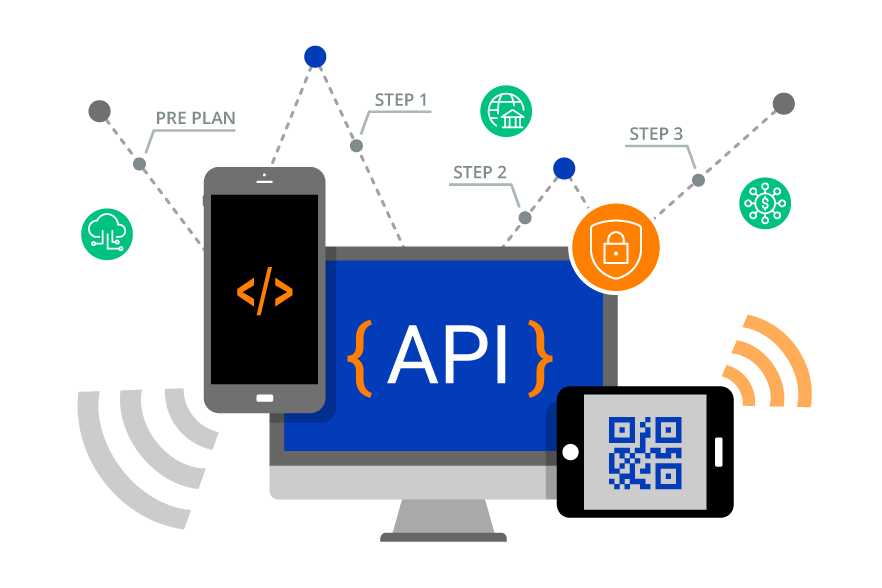